# Future work extra machine example


For this code, the time for machine 3 was adjusted to highlight a real world scenario where a particular machine takes longer to produce the order. 

In [15]:
import random
import matplotlib.pyplot as plt
def generateData_futurework(machines=4, jobs=7, seed=0):
    PROC = [ [ 0 for m in range(machines) ] for j in range(jobs) ]
    random.seed(seed)
    for j in range(jobs):
        ''' ADJUSTED CODE'''
        for m in range(machines):
            if m ==2:
                PROC[j][m] = random.randint(5,9)
            else:
                PROC[j][m] = random.randint(1,9)
    return PROC

In [16]:
PROC = generateData_futurework(machines=4, jobs=100, seed=9525)
print(PROC)

[[3, 5, 7, 6], [4, 8, 7, 4], [9, 4, 7, 4], [6, 5, 9, 2], [7, 9, 5, 4], [8, 8, 6, 4], [8, 2, 8, 9], [9, 5, 6, 8], [5, 4, 7, 1], [7, 5, 8, 2], [1, 6, 7, 9], [7, 3, 8, 1], [2, 4, 5, 8], [3, 5, 7, 2], [3, 9, 5, 5], [9, 8, 5, 9], [7, 9, 7, 1], [2, 5, 5, 8], [1, 5, 5, 9], [5, 4, 8, 9], [2, 3, 8, 3], [1, 4, 6, 5], [2, 6, 9, 3], [7, 2, 7, 8], [7, 3, 7, 9], [5, 9, 9, 3], [9, 4, 5, 1], [5, 5, 9, 3], [1, 2, 7, 2], [4, 4, 5, 4], [2, 8, 5, 1], [8, 5, 7, 8], [5, 3, 9, 9], [1, 5, 9, 9], [9, 1, 6, 9], [5, 9, 9, 4], [1, 5, 7, 6], [1, 1, 7, 6], [3, 3, 7, 1], [4, 3, 8, 6], [1, 2, 5, 1], [7, 5, 7, 2], [5, 8, 9, 1], [6, 6, 6, 4], [5, 7, 5, 4], [1, 2, 8, 6], [4, 3, 6, 7], [4, 4, 9, 2], [6, 2, 8, 5], [8, 6, 5, 8], [7, 1, 8, 6], [1, 8, 9, 3], [3, 1, 6, 7], [9, 5, 8, 4], [8, 8, 9, 7], [8, 4, 8, 2], [5, 8, 9, 8], [1, 3, 8, 9], [8, 9, 6, 6], [3, 3, 6, 3], [9, 3, 7, 6], [1, 8, 7, 8], [7, 3, 8, 1], [1, 9, 8, 1], [6, 9, 9, 2], [5, 4, 6, 8], [9, 3, 9, 2], [2, 1, 6, 4], [2, 4, 6, 8], [4, 5, 8, 5], [8, 7, 5, 9], [1, 8

## Linear Programming code from lecturer - Unchanged from what was provided

In [17]:
import pulp

def IP(PROC):

    steps = [ len(job) for job in PROC ]
    assert(min(steps)==max(steps))
    N_MACHINES = len(PROC[0])
    N_JOBS = len(PROC)


    def val(x):
        return int(pulp.value(x))

    def proc(job, machine):
        return pulp.lpSum( [ PROC[j][machine] * JJ[job][j] for j in range(N_JOBS) ] ) 

    JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)), lowBound=0, upBound=1, cat='Integer')
    Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')
    Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)), lowBound=0, cat='Integer')

    prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)
    prob += Stop[N_JOBS-1][N_MACHINES-1]

    # JJ is a permutation of the jobs
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
        prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

    for m in range(N_MACHINES):
        for j in range(N_JOBS):
            prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            prob += Start[j][m] + proc(j,m) == Stop[j][m]

    solvers = pulp.listSolvers(onlyAvailable=True) 
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
                
    return acc, int(pulp.value(prob.objective))

In [18]:
import numpy as np

def totalTime(PROC, seq, log=False):
    
    def isPermutation(seq):
        for i in range(len(seq)):
            if i not in seq:
                return False
        return True
    
    steps = [ len(job) for job in PROC ]
    assert(len(PROC) == len(seq))
    assert(isPermutation(seq))
    assert(min(steps)==max(steps))
    n_machines = len(PROC[0])
    n_jobs = len(PROC)
    wait = np.zeros([n_jobs, n_machines], dtype=int)
    idle = np.zeros([n_jobs, n_machines], dtype=int)
    start = np.zeros([n_jobs, n_machines], dtype=int)
    stop  = np.zeros([n_jobs, n_machines], dtype=int)
    proc = np.zeros([n_jobs, n_machines], dtype=int)
    for job in range(n_jobs):
        proc[job] = PROC[seq[job]]
    for job in range(n_jobs):
        for machine in range(n_machines):
            start[job, machine] = max(stop[job-1, machine] if job>0 else 0, stop[job, machine-1] if machine>0 else 0)
            wait[job, machine] = start[job, machine] - (stop[job, machine-1] if machine>0 else 0)
            idle[job, machine] = start[job, machine] - (stop[job-1, machine] if job>0 else 0)
            stop[job, machine] = start[job, machine] + proc[job, machine]

    if log:

        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)
        
        row = '|         |'
        for m in range(n_machines):
            row += f"            |" \
                    f" Machine: {m:1d} |"
        print(row)
        
        for j in range(n_jobs):
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Idle: {idle[j,m]:4d} |"
            print(row)
            
            row = '|---------|'
            for m in range(n_machines):
                row += f"------------|" \
                       f"------------|"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Start:{start[j,m]:4d} |"  
            print(row)
            
            row = f'| Job: {seq[j]:2d} |'
            for m in range(n_machines):
                row += f" Wait: {wait[j,m]:4d} | " \
                       f"Proc: {proc[j,m]:4d} |"
            print(row)
            
            row = '|         |'
            for m in range(n_machines):
                row += f"       {' ':4s} | " \
                       f"Stop: {stop[j,m]:4d} |"  
            print(row)
            
        row = '|---------|'
        for m in range(n_machines):
            row += f"------------|" \
                    f"------------|"
        print(row)

    
    return stop[n_jobs-1, n_machines-1]                                                       

## New Code to graph example

In [19]:
seq, proctime = IP(PROC)
print(seq)
print(proctime)
totalTime(PROC, seq)

[37, 45, 43, 87, 70, 20, 5, 2, 76, 99, 23, 44, 30, 29, 47, 59, 86, 64, 41, 65, 24, 79, 51, 72, 34, 40, 74, 31, 61, 89, 90, 73, 13, 46, 53, 97, 56, 98, 7, 22, 17, 52, 48, 95, 28, 69, 15, 19, 63, 91, 10, 92, 83, 0, 1, 75, 84, 6, 71, 54, 57, 50, 81, 21, 3, 58, 78, 12, 4, 68, 8, 60, 36, 32, 62, 66, 55, 35, 26, 42, 39, 25, 93, 18, 9, 96, 94, 38, 27, 88, 14, 82, 49, 77, 33, 11, 67, 85, 80, 16]
699


699

In [34]:
import pandas as pd

df = pd.DataFrame(PROC)
df.columns = ["Machine 1","Machine 2","Machine 3","Machine 4"]

Machine 1    4.76
Machine 2    4.97
Machine 3    6.96
Machine 4    4.86
dtype: float64


Machine 1    4.76
Machine 2    4.97
Machine 3    6.96
Machine 4    4.86
dtype: float64


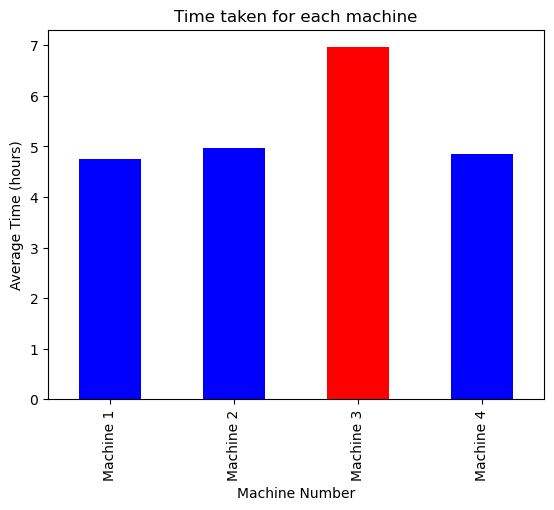

In [35]:
means = df.mean()
print(means)
means.plot.bar(xlabel= 'Machine Number', ylabel = 'Average Time (hours)',title = 'Time taken for each machine', color = ['b','b','r','b'])
plt.savefig('output_figures/future_work_example.png')
#plt.errorbar(df.index)